In [1]:
import os
# os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.9'
import jax
import jax.numpy as jnp
from jax import random,  vmap, jit
from jax import config
# from jax.ops import index_update, index
from jax import lax
from jax.flatten_util import ravel_pytree

import itertools
from functools import partial
from tqdm.auto import trange, tqdm
import time

from scipy.interpolate import griddata
from scipy.sparse import csr_matrix

import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
# plt.rcParams.update({'font.size': 5})

config.update("jax_enable_x64", True)

In [2]:
a0 = np.load("A42.npy")
a1 = np.load("A421.npy")
a2 = np.load("A422.npy")
unique_results = np.concatenate((a0, a1, a2), axis=0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


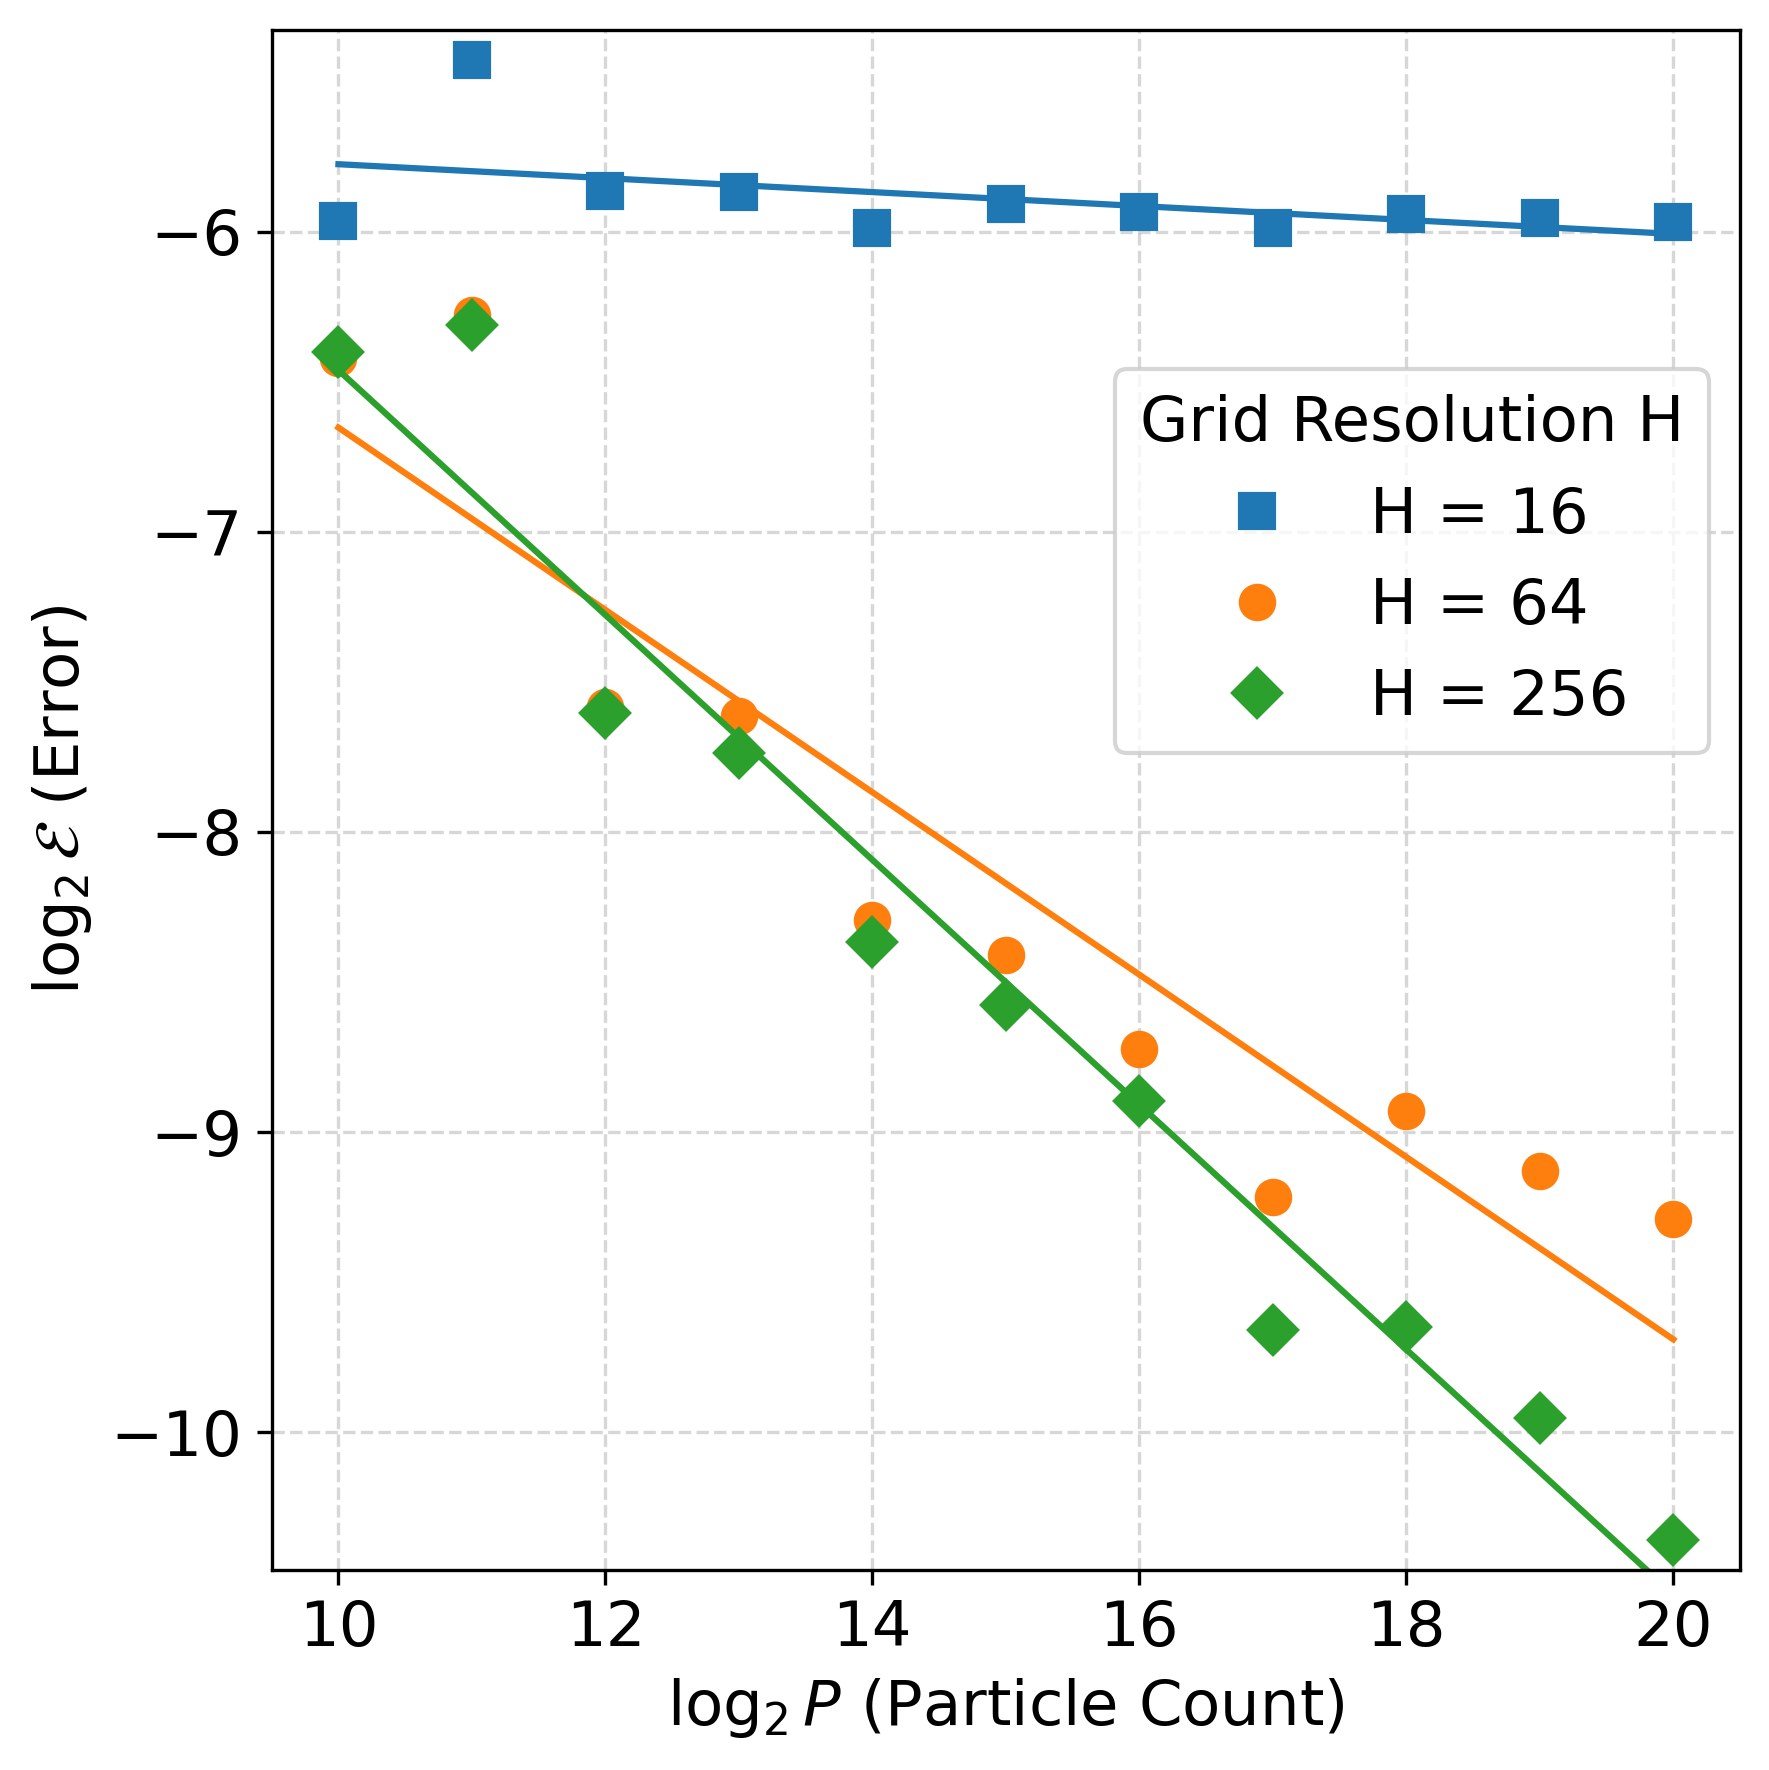

In [3]:
data_sizes = sorted(set(x[0] for x in unique_results)) 
param_sizes = [16, 64, 256]
marker_dict = {
    16: 's', 
    64: 'o', 
    256: 'D'
}

performance_dict = {param: [] for param in param_sizes}

for data_size in data_sizes:
    for param in param_sizes:
        performances = [x[2] for x in unique_results if x[0] == data_size and x[1] == param]
        if performances:
            average_performance = np.mean(performances)
            performance_dict[param].append((data_size, average_performance))

plt.figure(figsize=(6, 6))
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['text.usetex'] = False

for param, values in performance_dict.items():
    data_sizes, performances = zip(*values)  
    log_data_sizes = np.log2(data_sizes)
    log_performances = np.log2(performances)
    
    # 1. Plot data points WITHOUT connecting lines
    plt.plot(log_data_sizes, log_performances, 
             marker=marker_dict[param], 
             markersize=8, 
             linestyle='none',  # <--- Remove connecting lines
             label=f'H = {param}')
    
    # 2. Calculate and plot fitted line
    slope, intercept = np.polyfit(log_data_sizes, log_performances, 1)
    fitted_line = slope * np.array(log_data_sizes) + intercept
    plt.plot(log_data_sizes, fitted_line, 
             linestyle='-', 
             color=plt.gca().lines[-1].get_color())  # Match marker color

plt.xlabel(r'$\log_2 P$ (Particle Count)', fontsize=15)
plt.ylabel(r'$\log_2 \mathcal{E}$ (Error)', fontsize=15)
plt.tick_params(axis='both', labelsize=15)

plt.legend(title='Grid Resolution H', loc='upper right', 
           fontsize=15, title_fontsize=15, bbox_to_anchor=(1, 0.8)) 

max_log_performance = max(np.log2(p) for param in performance_dict for _, p in performance_dict[param])
min_log_performance = min(np.log2(p) for param in performance_dict for _, p in performance_dict[param])
plt.ylim(min_log_performance - 0.1, max_log_performance + 0.1)

plt.grid(True, linestyle='--', alpha=0.5) 
plt.tight_layout()

plt.savefig('convergence_4_2.eps', format='eps', dpi=300, bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


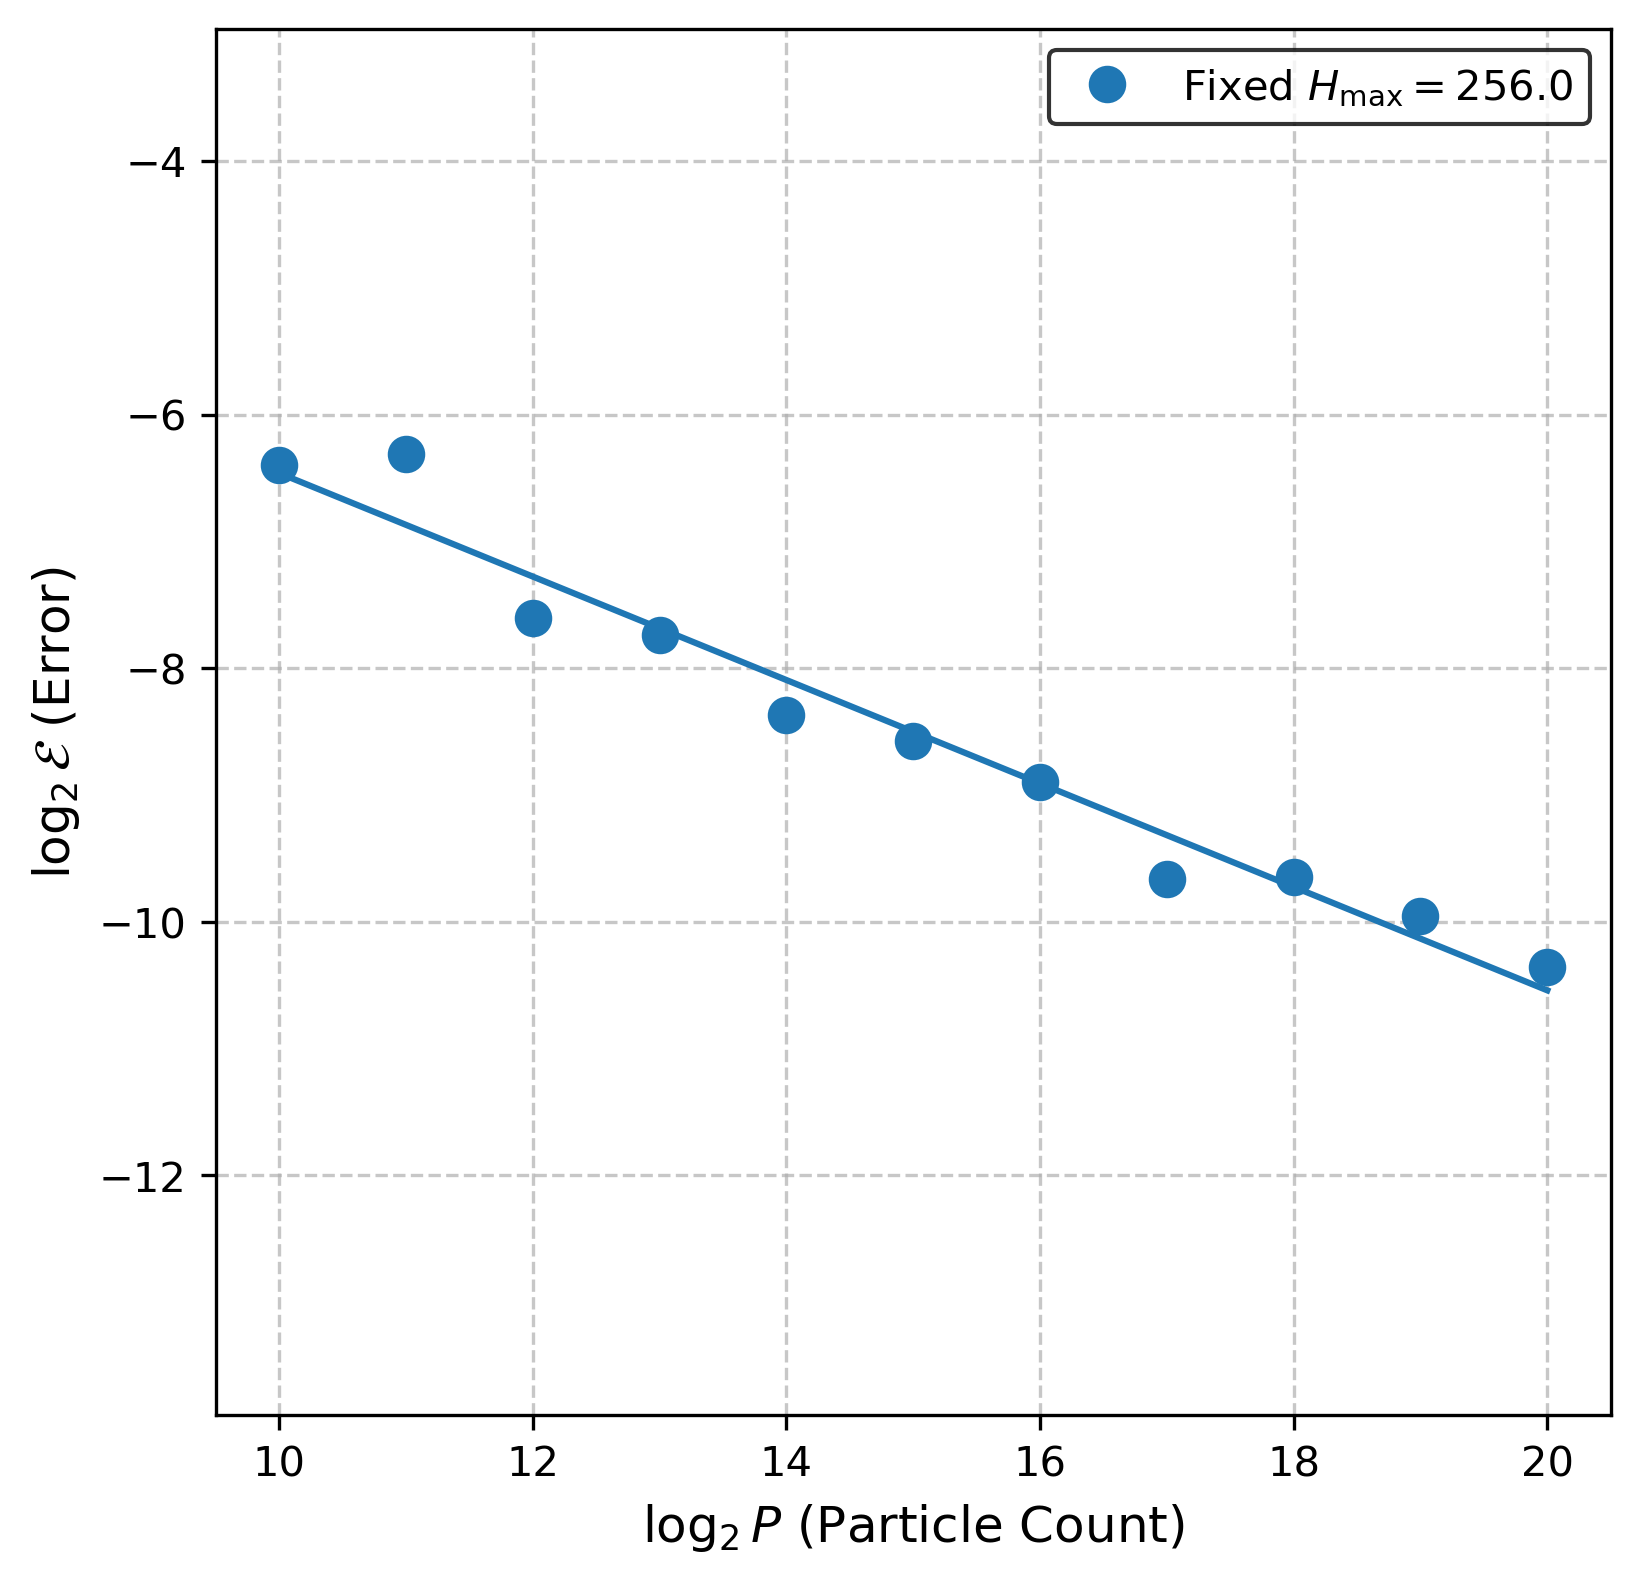

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


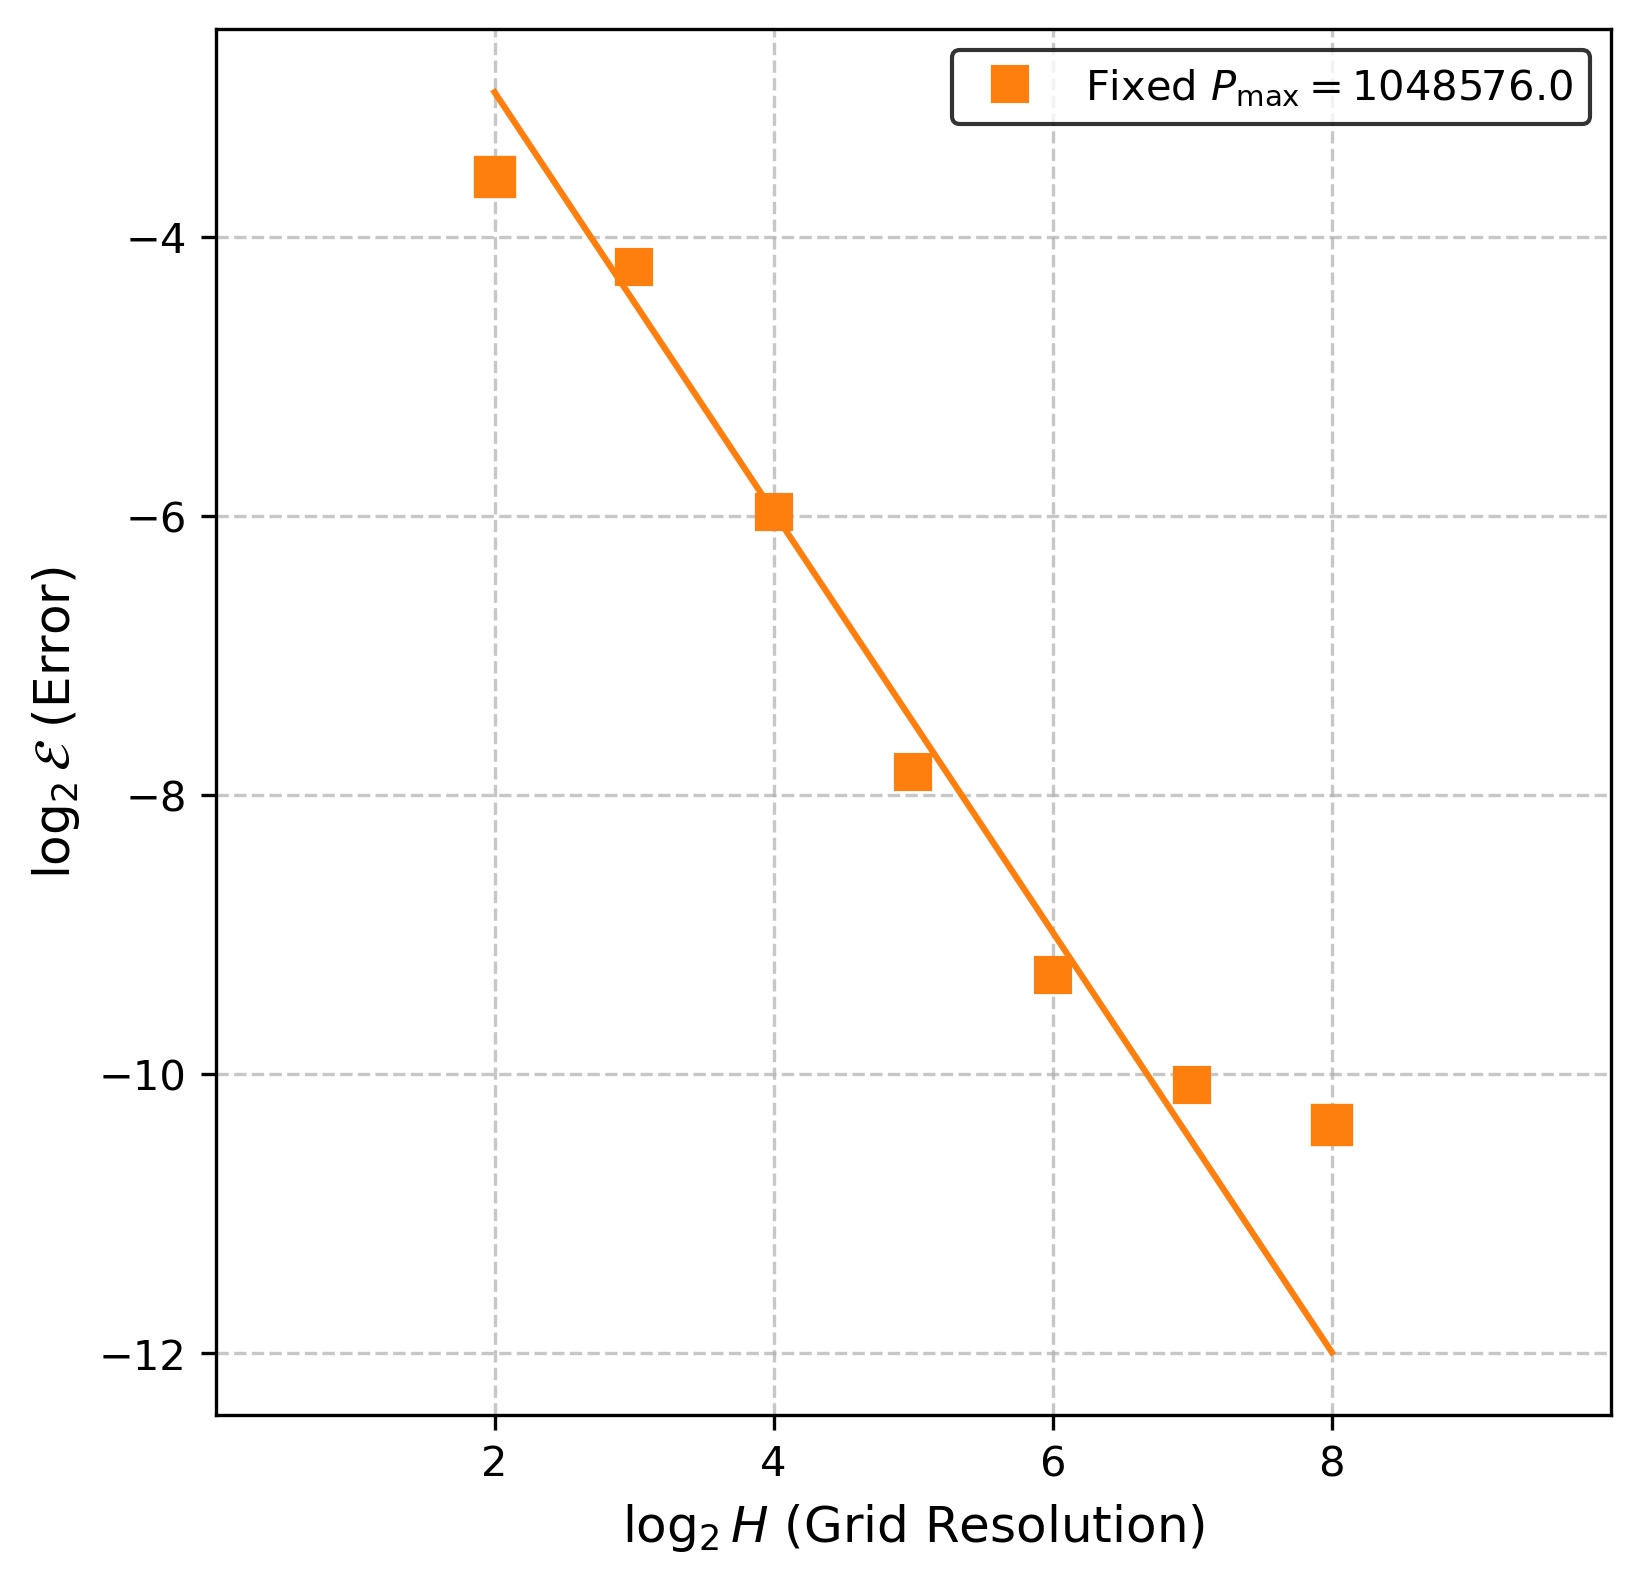

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# ====== 数据预处理 ======
# 获取所有唯一的粒子数P和网格数H并排序
data_sizes = sorted(set(x[0] for x in unique_results))  # 对应粒子数P
param_sizes = sorted(set(x[1] for x in unique_results)) # 对应网格数H

# ====== P收敛性分析 (固定H_max) ======
# 筛选H_max对应的最大网格分辨率
H_max = max(param_sizes)
P_errors_dict = {}

# 收集所有P值对应的误差 (考虑多次测量)
for x in unique_results:
    if x[1] == H_max:
        P_val = x[0]
        error = x[2]
        if P_val not in P_errors_dict:
            P_errors_dict[P_val] = []
        P_errors_dict[P_val].append(error)

# 计算平均误差
P_vals = []
avg_errors = []
for P_val, errors in sorted(P_errors_dict.items()):
    avg_error = np.mean(errors)
    P_vals.append(P_val)
    avg_errors.append(avg_error)

if len(P_vals) >= 2:  # 至少需要2个点才能拟合
    # 转换为对数坐标
    log_P_vals = np.log2(P_vals)
    log_errors = np.log2(avg_errors)
    
    # 计算线性拟合 (使用所有点)
    slope, intercept = np.polyfit(log_P_vals, log_errors, 1)
    fitted_line = slope * np.array(log_P_vals) + intercept
    
    # 绘制P收敛性
    plt.figure(figsize=(6,6))
    
    # 绘制数据点 (无连接线)
    plt.plot(log_P_vals, log_errors, 
             marker='o', color='#1f77b4', linewidth=0,  # linewidth=0 移除连接线
             markersize=8, 
             label=f'Fixed $H_{{\max}}={H_max}$')
    
    # 绘制拟合线
    plt.plot(log_P_vals, fitted_line, 
             linestyle='-', color='#1f77b4', linewidth=1.5)
    
    plt.xlabel(r'$\log_2 P$ (Particle Count)', fontsize=12)
    plt.ylabel(r'$\log_2 \mathcal{E}$ (Error)', fontsize=12)
    plt.axis('equal')
    plt.legend(frameon=True, edgecolor='k')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig('convergence_4_2_P.eps', format='eps', dpi=300, bbox_inches='tight')
    plt.show()

# ====== H收敛性分析 (固定P_max) ======
# 筛选P_max对应的最大粒子数
P_max = max(data_sizes)
H_errors_dict = {}

# 收集所有H值对应的误差 (考虑多次测量)
for x in unique_results:
    if x[0] == P_max:
        H_val = x[1]
        error = x[2]
        if H_val not in H_errors_dict:
            H_errors_dict[H_val] = []
        H_errors_dict[H_val].append(error)

# 计算平均误差
H_vals = []
avg_errors = []
for H_val, errors in sorted(H_errors_dict.items()):
    avg_error = np.mean(errors)
    H_vals.append(H_val)
    avg_errors.append(avg_error)

if len(H_vals) >= 4:  # 至少需要4个点才能排除首尾后还有足够点拟合
    # 转换为对数坐标
    log_H_vals = np.log2(H_vals)
    log_errors = np.log2(avg_errors)
    
    # 排除第一个和最后一个点进行拟合
    fit_indices = range(1, len(log_H_vals)-1)  # 排除首尾点
    slope, intercept = np.polyfit(
        [log_H_vals[i] for i in fit_indices], 
        [log_errors[i] for i in fit_indices], 
        1
    )
    
    # 生成拟合线 (使用所有点范围)
    fitted_line = slope * np.array(log_H_vals) + intercept
    
    # 绘制H收敛性
    plt.figure(figsize=(6,6))
    
    # 绘制所有数据点
    plt.plot(log_H_vals, log_errors, 
             marker='s', color='#ff7f0e', linewidth=0,  # linewidth=0 移除连接线
             markersize=8, 
             label=f'Fixed $P_{{\max}}={P_max}$')
    
    # 特别标记被排除的点
    plt.plot(log_H_vals[0], log_errors[0], 's', markersize=8, 
             markerfacecolor='none', markeredgecolor='#ff7f0e', 
             markeredgewidth=2)
    plt.plot(log_H_vals[-1], log_errors[-1], 's', markersize=8, 
             markerfacecolor='none', markeredgecolor='#ff7f0e', 
             markeredgewidth=2)
    
    # 绘制拟合线
    plt.plot(log_H_vals, fitted_line, 
             linestyle='-', color='#ff7f0e', linewidth=1.5)
    
    plt.xlabel(r'$\log_2 H$ (Grid Resolution)', fontsize=12)
    plt.ylabel(r'$\log_2 \mathcal{E}$ (Error)', fontsize=12)
    plt.axis('equal')
    plt.legend(frameon=True, edgecolor='k')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig('convergence_4_2_H.eps', format='eps', dpi=300, bbox_inches='tight')
    plt.show()
elif len(H_vals) >= 2:  # 如果点数不足4个但至少有2个，使用所有点拟合
    # 转换为对数坐标
    log_H_vals = np.log2(H_vals)
    log_errors = np.log2(avg_errors)
    
    # 计算线性拟合 (使用所有点)
    slope, intercept = np.polyfit(log_H_vals, log_errors, 1)
    fitted_line = slope * np.array(log_H_vals) + intercept
    
    # 绘制H收敛性
    plt.figure(figsize=(6,6))
    
    # 绘制数据点 (无连接线)
    plt.plot(log_H_vals, log_errors, 
             marker='s', color='#ff7f0e', linewidth=0,  # linewidth=0 移除连接线
             markersize=8, 
             label=f'Fixed $P_{{\max}}={P_max}$')
    
    # 绘制拟合线
    plt.plot(log_H_vals, fitted_line, 
             linestyle='-', color='#ff7f0e', linewidth=1.5)
    
    plt.xlabel(r'$\log_2 H$ (Grid Resolution)', fontsize=12)
    plt.ylabel(r'$\log_2 \mathcal{E}$ (Error)', fontsize=12)
    plt.axis('equal')
    plt.legend(frameon=True, edgecolor='k')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig('convergence_4_2_H.eps', format='eps', dpi=300, bbox_inches='tight')
    plt.show()